In [1]:
! which python3
! python3 -V

/home/mykmur/dev/venv/bin/python3
Python 3.8.15


In [2]:
import typing as t
import jraph
import jax.numpy as jnp
import metadata
import haiku as hk
import utils
import jax
import optax

In [3]:
WINDOW = int(31*12*24*60/5)
VIS = False

In [4]:
def create_graph_tuple(senders, receivers, edges) -> jraph.GraphsTuple:
    return jraph.GraphsTuple(
        nodes=None,
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.asarray([metadata.NUM_NODES]),
        n_edge=jnp.asarray([metadata.NUM_EDGES]),
        globals=None)

In [5]:
_senders = []
_receivers = []

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * metadata.NUM_NODES)
edges = jnp.array([1] * metadata.NUM_EDGES)

graph_features = jnp.array([[1]])
graph = create_graph_tuple(senders, receivers, edges)

if VIS:
    utils.draw_jraph_graph_structure(graph)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Load data

In [6]:
import pandas as pd

In [7]:
df = pd.read_pickle("../data/samples_5m_subset_v1.pkl")

In [8]:
def get_data_for_link(src: str, dst: str) -> jnp.array:
    ss: pd.Series = df[(df["src_host"] == src) & (df["dst_host"] == dst)]
    return ss.incoming_rate_avg.to_numpy()

In [9]:
_map = metadata.NODE_IDS_TO_LABELS_MAPPING

_senders = []
_receivers = []
_edges = jnp.array([[]])

for x, row in enumerate(metadata.ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if metadata.ADJACENCY_MATRIX[x][y]:
            _edges = jnp.append(_edges,
                get_data_for_link(_map[x], _map[y]))
                
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
edges = jnp.array(_edges.reshape((metadata.NUM_EDGES, int(len(_edges)/metadata.NUM_EDGES))))

In [10]:
graph = create_graph_tuple(senders, receivers, edges)

In [11]:
if VIS:
    utils.draw_jraph_graph_structure(graph)

### Model

In [12]:
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
SPLIT = 0.9
BLOCK_SIZE = int(24*60/5)  # 1 day
BATCH_SIZE = 32
SEED = 1237
NUM_TRAINING_STEPS = 400
EVAL_INTERVAL = 10

In [13]:
n = int(SPLIT * edges.shape[1])
d_train = edges[0][:n]
d_val = edges[0][n:]

In [14]:
d_train = jnp.log(d_train)
d_val = jnp.log(d_val)

In [15]:
d_val.shape, d_train.shape, edges.shape

((16227,), (146043,), (15, 162270))

In [16]:
class TrainingState(t.NamedTuple):
    params: hk.Params
    opt_state: optax.OptState

class LoopValues(t.NamedTuple):
    tokens: jnp.ndarray
    state: t.Any
    rng_key: jnp.ndarray

Batch = t.Mapping[str, jnp.ndarray]

In [17]:
the_seed = hk.PRNGSequence(SEED)

def get_batch(split: str) -> Batch:
    data = d_train if split == "train" else d_val
    ixs = jax.random.randint(next(the_seed), (BATCH_SIZE, ), 0, len(data) - BLOCK_SIZE)
    x = jnp.stack([data[i:i+BLOCK_SIZE] for i in ixs])
    y = jnp.stack([data[i+1:i+BLOCK_SIZE+1] for i in ixs])
    return {'input': x, 'target': y}

In [18]:
expl_batch = get_batch("train")

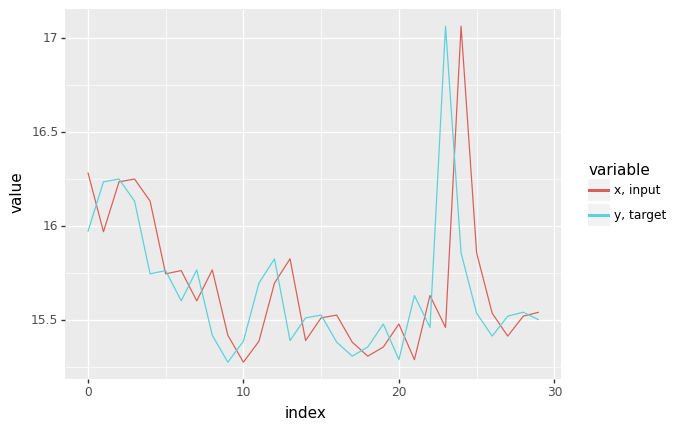

In [113]:
_off = 30
plot = utils.plot_samples(
    truth=expl_batch['target'][0, :_off], 
    prediction=expl_batch['input'][0, :_off],
    truth_label='y, target',
    prediction_label='x, input')
plot.draw()

In [20]:
def make_network() -> hk.Module:
    """Defines the network architecture."""
    model = hk.DeepRNN([
        hk.LSTM(HIDDEN_SIZE),
        jax.nn.relu,
        hk.LSTM(HIDDEN_SIZE),
    ])
    return model

def make_optimizer() -> optax.GradientTransformation:
    """Defines the optimizer."""
    return optax.adam(LEARNING_RATE)

In [89]:
def sequence_loss(batch: Batch) -> jnp.ndarray:
    """Unrolls the network over a sequence of inputs & targets, gets loss."""
    core = make_network()
    batch_size, sequence_length = batch['input'].shape  # (B, T) 

    initial_state = core.initial_state(batch_size)

    _input = jnp.expand_dims(batch['input'], -1)  # (B, T, 1)

    logits, _ = hk.dynamic_unroll(core, _input, initial_state, time_major=False)  # (B, T, HIDDEN_SIZE)

    logits_batched = hk.BatchApply(hk.Linear(1))(logits)  # (B, T, 1)

    loss = jnp.mean(jnp.abs(batch['target'] - logits_batched[:, :, -1]))  # MAE
    return loss

In [22]:
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
    """Does a step of SGD given inputs & targets."""
    _, optimizer = make_optimizer()
    _, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
    gradients = jax.grad(loss_fn)(state.params, batch)
    updates, new_opt_state = optimizer(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)
    return TrainingState(params=new_params, opt_state=new_opt_state)

In [23]:
expl_batch['target'].shape

(32, 288)

In [24]:
rng = hk.PRNGSequence(SEED)

init_params_fn, loss_fn = hk.without_apply_rng(hk.transform(sequence_loss))
initial_params = init_params_fn(next(rng), expl_batch)
opt_init, _ = make_optimizer()
initial_opt_state = opt_init(initial_params)

# de facto initial state
state = TrainingState(params=initial_params, opt_state=initial_opt_state)

In [25]:
loss_fn = jax.jit(loss_fn)

In [26]:
train_loss_all = jnp.array([])
eval_loss_all = jnp.array([])

for step in range(NUM_TRAINING_STEPS):
    train_batch = get_batch("train")
    state = update(state, train_batch)

    if step % EVAL_INTERVAL == 0:
        eval_batch = get_batch("eval")
        train_loss = loss_fn(state.params, train_batch)
        eval_loss = loss_fn(state.params, eval_batch)
        train_loss_all = jnp.append(train_loss_all, train_loss)
        eval_loss_all = jnp.append(eval_loss_all, eval_loss)
        print({
            'step': step,
            'train_loss': float(train_loss),
            'eval_loss': float(eval_loss),
        })

final_state = state

{'step': 0, 'train_loss': 251.17591857910156, 'eval_loss': 252.1622772216797}
{'step': 10, 'train_loss': 49.47808074951172, 'eval_loss': 51.62349319458008}
{'step': 20, 'train_loss': 10.436286926269531, 'eval_loss': 9.654254913330078}
{'step': 30, 'train_loss': 2.911381721496582, 'eval_loss': 2.602782964706421}
{'step': 40, 'train_loss': 2.487769603729248, 'eval_loss': 2.2800819873809814}
{'step': 50, 'train_loss': 2.5853309631347656, 'eval_loss': 2.238784074783325}
{'step': 60, 'train_loss': 2.0673253536224365, 'eval_loss': 1.8243399858474731}
{'step': 70, 'train_loss': 1.8504869937896729, 'eval_loss': 1.7923948764801025}
{'step': 80, 'train_loss': 1.987418293952942, 'eval_loss': 1.7420345544815063}
{'step': 90, 'train_loss': 1.688607931137085, 'eval_loss': 1.6941218376159668}
{'step': 100, 'train_loss': 1.5736397504806519, 'eval_loss': 1.4768730401992798}
{'step': 110, 'train_loss': 1.6952269077301025, 'eval_loss': 1.347044587135315}
{'step': 120, 'train_loss': 1.5685316324234009, 'e

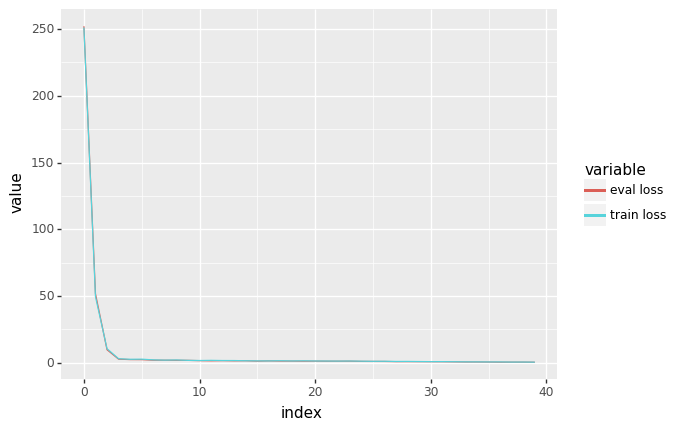

In [27]:

plot = utils.plot_samples(
    truth=train_loss_all, 
    prediction=eval_loss_all,
    truth_label='train loss',
    prediction_label='eval loss')
plot.draw()

### Generating data from the model

In [102]:
def generate(context: jnp.ndarray, seq_len: int) -> jnp.array:
    """Draws samples from the model, given an initial context."""
    core = make_network()
    dense = hk.Linear(1)

    batch_size, sequence_length = context.shape  # (B, T)

    initial_state = core.initial_state(batch_size)

    _input = jnp.expand_dims(context, -1)  # (B, T, 1)
    _input = jnp.reshape(_input, (288, 1, 1))

    context_outs, state = hk.dynamic_unroll(core, _input, initial_state)
    context_outs = hk.BatchApply(dense)(context_outs)

    # Now, unroll one step at a time using the running recurrent state.
    _outs = []
    logits = context_outs[-1]
    for _ in range(seq_len - sequence_length):
        logits, state = core(logits, state)
        logits = dense(logits)
        _outs.append(logits)

    return jnp.concatenate([context_outs, jnp.stack(_outs)])

In [103]:
fast_ar_predict = hk.transform(generate)
fast_ar_predict = jax.jit(fast_ar_predict.apply, static_argnums=3)

In [128]:
val_batch = get_batch("valid")
context = val_batch["input"][:1, :]
predicted = fast_ar_predict(final_state.params, None, context, 600)

In [129]:
context.shape, predicted.shape, val_batch["target"].shape

((1, 288), (600, 1, 1), (32, 288))

In [130]:
print(f" MAE: {jnp.mean(jnp.abs(context[-1, :] - predicted[:288, -1, -1])):.4f}")
print(f" MSE: {jnp.mean(jnp.square(context[-1, :] - predicted[:288, -1, -1])):.4f}")

 MAE: 0.2898
 MSE: 0.2380


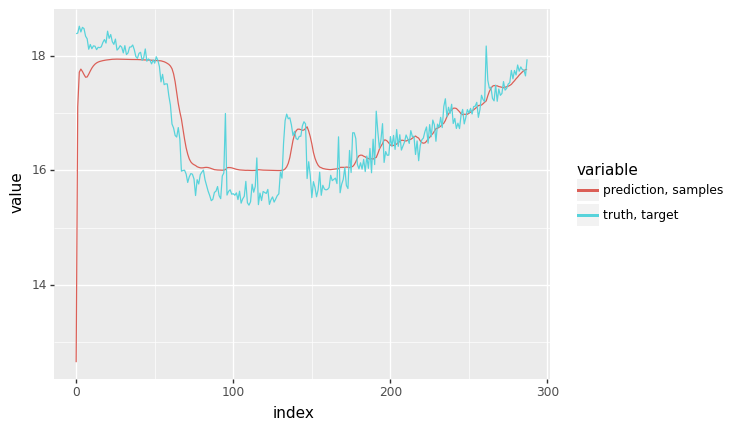

In [131]:
plot = utils.plot_samples(
    val_batch["target"][0, :],
    predicted[:288, -1, -1],
    truth_label='truth, target',
    prediction_label='prediction, samples')
plot.draw()